# BushFire class

This class is used to model the bushfire hazard using the historical data available (FIRMS data) and creating probabilistic events for each historical event. 

The historical data used are the data in FIRMS (https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/about-firms) coming from:
. MODIS (Near Real Time (NRT) or standard quality data) - data resolution: 1 km - data available from November 2000 to present
. VIIRS (NRT data) - data resolution: 0.375 m - data available from 20 January 2012 to present.
We recommand to not mix the two datasets and to use first the VIIRS data when available (as their resolution is higher). However the Bushfire script can deal with the two different datasets in terms of resolution and data cleaning. 

The data can be obtained at https://firms.modaps.eosdis.nasa.gov/download/ and have to be saved as .csv file. Approximatly 15 min after submitting the request, the data can be downloaded by checking the request status. 

The BushFire class inherits from the Hazard class. It provides a set_bushfire() method which enables to model bushfires for a given geographical area. 

With the next commands we can model the fires of the state of California in 2016 and the Soberanes fire that burned in July 2016 in California. 

The seed is an optional input value allowing for the reproducibility of the probabilistic simulations. Put a negative number if you don't want to use it. 

2019-04-09 09:17:24,037 - climada.hazard.bush_fire - INFO - Setting up historical event.
firms size: %s with threshold = %s 332670 30
2019-04-09 09:17:25,377 - climada.hazard.bush_fire - INFO - Computing clusters of consecutive days.
nb of temporal clusters 0.0
2019-04-09 09:17:28,874 - climada.hazard.bush_fire - INFO - Defining the resolution of the centroids.
2019-04-09 09:17:28,881 - climada.hazard.bush_fire - INFO - Computing centroids.
2019-04-09 09:17:47,571 - climada.hazard.bush_fire - INFO - Computing geographic clusters in consecutive events.
Nb of geographical clusters 129.0
2019-04-09 09:17:50,273 - climada.hazard.bush_fire - INFO - Sorting of firms data
2019-04-09 09:17:50,390 - climada.hazard.bush_fire - INFO - Creation of event_id.
Nb of event 130.0
2019-04-09 09:17:52,531 - climada.hazard.bush_fire - DEBUG - Filling up the matrix.


(<Figure size 648x936 with 2 Axes>,
 array([[<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x1a2f19e128>]],
       dtype=object))

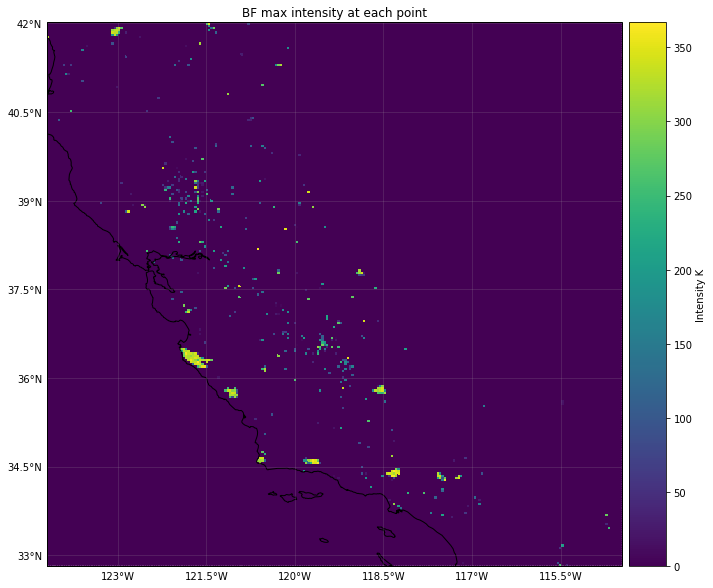

In [8]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_2016_viirs.csv")

bf = BushFire()
Fire_California_2016 = bf.set_bush_fire (TEST_FIRMS, centr_res_factor = 0.25, seed = -4)
bf.plot_intensity(event=0)


2019-04-09 09:12:16,815 - climada.hazard.bush_fire - INFO - Setting up historical event.
firms size: %s with threshold = %s 139875 30
2019-04-09 09:12:17,301 - climada.hazard.bush_fire - INFO - Computing clusters of consecutive days.
nb of temporal clusters 1.0
2019-04-09 09:12:18,224 - climada.hazard.bush_fire - INFO - Defining the resolution of the centroids.
2019-04-09 09:12:18,227 - climada.hazard.bush_fire - INFO - Computing centroids.
2019-04-09 09:12:28,842 - climada.hazard.bush_fire - INFO - Computing geographic clusters in consecutive events.
Nb of geographical clusters 3.0
2019-04-09 09:12:30,858 - climada.hazard.bush_fire - INFO - Sorting of firms data
2019-04-09 09:12:30,926 - climada.hazard.bush_fire - INFO - Creation of event_id.
Nb of event 5.0
2019-04-09 09:12:31,488 - climada.hazard.bush_fire - DEBUG - Filling up the matrix.


(<Figure size 648x936 with 2 Axes>,
 array([[<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x1a2e779940>]],
       dtype=object))

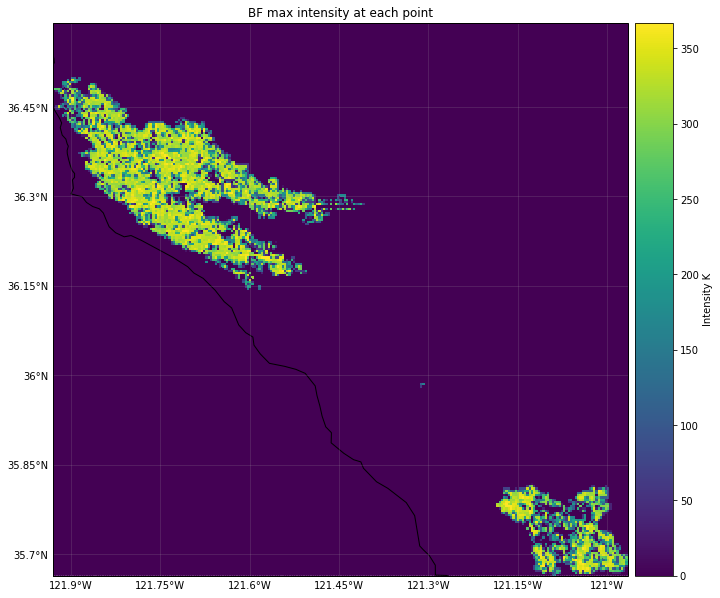

In [4]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_Soberanes_2016_viirs.csv")

bf = BushFire()
Fire_Soberanes = bf.set_bush_fire (TEST_FIRMS, centr_res_factor = 1, seed = 8)
bf.plot_intensity(event=0)

## Clean data file
The dataset can be cleaned from low confidence data by using the method _clean_firms_csv.

If the data origin is VIIRS, the data with 'l' as confidence value will be removed from the dataset. 
If the data origin is MODIS, the confidence value is numerical and the threshold below which the data are removed can be chosen by changing the value of CLEAN_THRESH. Per default, this value is set at 30 as recommanded by Earthdata. 

In [6]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
import numpy as np
import pandas as pd
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_Soberanes_2016_modis.csv")

CLEAN_THRESH = 50
""" Minimal confidence value for the data from MODIS instrument to be use as input"""

bf = BushFire()
firms, description = bf._read_firms_csv(TEST_FIRMS)

temp = pd.DataFrame()
if 'instrument' in firms.columns:
    if firms.instrument.any() == 'MODIS' or firms.instrument.any() == 'VIIRS':
        firms_modis = firms.drop(firms[firms.instrument == 'VIIRS'].index)
        firms_modis.confidence = np.array(
                    list(map(int, firms_modis.confidence.values.tolist())))
        firms_modis = firms_modis.drop(firms_modis[firms_modis.confidence < CLEAN_THRESH].index)
        temp = firms_modis
        firms_viirs = firms.drop(firms[firms.instrument == 'MODIS'].index)
        if firms_viirs.size:
            firms_viirs = firms_viirs.drop(firms_viirs[firms_viirs.confidence == 'l'].index)
            firms_viirs = firms_viirs.rename(columns={'bright_ti4':'brightness'})
            temp = temp.append(firms_viirs, sort = True)

    firms = temp
print('firms size:', str(firms.size),'with threshold =', str(CLEAN_THRESH))



firms size: 32944 with threshold = 50


## Centroids
The centroids are created for the dataset with the method _centroids_creation

The number of centroids is defined according to the data resolution (res_data), which depends on the origin of the data. If the data origin is not provided, the resolution can be chosen manually with the constant RES_DATA. 
A factor (centr_res_factor) is used as a multiplier to voluntarly decrease/increase the number of centroids in the latitude and longitude directions, independently from the data resolution itself. 

In [10]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
import numpy as np
import pandas as pd
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_Soberanes_2016_modis.csv")

bf = BushFire()
firms, description = bf._read_firms_csv(TEST_FIRMS)
firms = bf._clean_firms_csv(firms)

centr_res_factor = 1
centroids, res_data = bf._centroids_creation(firms, centr_res_factor)

firms size: %s with threshold = %s 37248 30
2019-04-09 09:21:38,500 - climada.hazard.bush_fire - INFO - Defining the resolution of the centroids.
2019-04-09 09:21:38,502 - climada.hazard.bush_fire - INFO - Computing centroids.


## Temporal clustering

The temporal clustering of the data is done with the method firms_cons_days.
Temporal clusters are defined by data with consecutive acquisition dates, or with less than 2 days interruption.

## Geographical clustering
The geographical clustering of the data is done with the method _firms_clustering.

This method looks for geographical clusters in each of the temporal clusters.

This method uses the DBSCAN algorithm from scikit library, a Density-Based Spatial Clustering of Applications with Noise algorithm. It finds core samples of high density and expands clusters from them. DBSCAN requires two input parameters: eps and min_samples. 

eps corresponds to the maximum distance between two samples for them to be considered as in the same neighborhood and is set equal to half of the data resolution (as calculated previously with the centroids). 
min_samples corresponds to the number of samples (or total weight) in a neighborhood for a point to be considered as a core point (this includes the point itself). As we considered that a fire event can be composed of only one pixel, min_samples is set at 0 per default. 


## Number of events per year
The method _event_per_year_ allows to calculate the number of event for a given year.
Below the example for California in 2016.

In [11]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
import numpy as np
import pandas as pd
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_2016_viirs.csv")

bf = BushFire()
firms, description = bf._read_firms_csv(TEST_FIRMS)
firms = bf._firms_cons_days(firms)
centroids, res_data = bf._centroids_creation(firms, centr_res_factor = 1)
firms = bf._firms_clustering(firms, res_data)
firms = bf._firms_event(firms)

event_for_2016 = bf._event_per_year(firms, 2016)

2019-04-09 09:39:15,805 - climada.hazard.bush_fire - INFO - Computing clusters of consecutive days.
nb of temporal clusters 0.0
2019-04-09 09:39:17,717 - climada.hazard.bush_fire - INFO - Defining the resolution of the centroids.
2019-04-09 09:39:17,721 - climada.hazard.bush_fire - INFO - Computing centroids.
2019-04-09 09:45:35,256 - climada.hazard.bush_fire - INFO - Computing geographic clusters in consecutive events.
Nb of geographical clusters 129.0
2019-04-09 09:45:38,032 - climada.hazard.bush_fire - INFO - Sorting of firms data
2019-04-09 09:45:38,113 - climada.hazard.bush_fire - INFO - Creation of event_id.
Nb of event 130.0
year: 2016 nb of event: 130.0


## Intensity matrix

The intensity matrix is build with the method calc_brightness.
This method fills the intensity matrix with, for each event, the maximum measured brightness at each centroid. 

The closest centroid from each (lat, lon) points of the dataframe is identified with the help of a balltree. 

## Area burned per event
The method #_area_one_event_ allow to calculate the area burned (in km2) per event based on the number of centroids associated with a brightness value higher than 0. 

The calculated area is an approximation and does NOT correspond to the real area (due to projection issue). This value is used only to stop the propagation of the fire for the probabilistic events. 

Below the example of the area burned in 2016 during the Soberanes fire in California.

In [14]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
import numpy as np
import pandas as pd
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_Soberanes_2016_viirs.csv")

bf = BushFire()
firms, description = bf._read_firms_csv(TEST_FIRMS)
firms = bf._firms_cons_days(firms)
centroids, res_data = bf._centroids_creation(firms, centr_res_factor = 1)
firms = bf._firms_clustering(firms, res_data)
firms = bf._firms_event(firms)
brightness = bf._calc_brightness(firms, centroids)

area_Soberanes = bf._area_one_event(3) #3 = event_id of Soberanes fire

2019-04-09 09:52:55,021 - climada.hazard.bush_fire - INFO - Computing clusters of consecutive days.
nb of temporal clusters 1.0
2019-04-09 09:52:56,227 - climada.hazard.bush_fire - INFO - Defining the resolution of the centroids.
2019-04-09 09:52:56,230 - climada.hazard.bush_fire - INFO - Computing centroids.
2019-04-09 09:53:06,052 - climada.hazard.bush_fire - INFO - Computing geographic clusters in consecutive events.
Nb of geographical clusters 3.0
2019-04-09 09:53:07,785 - climada.hazard.bush_fire - INFO - Sorting of firms data
2019-04-09 09:53:07,822 - climada.hazard.bush_fire - INFO - Creation of event_id.
Nb of event 5.0
2019-04-09 09:53:08,365 - climada.hazard.bush_fire - DEBUG - Filling up the matrix.
area_one_event: 3 458.9417626798602


## Area burned per year
Based on the same principles, the area burned per year can be calculated using the method _area_one_year_.
Below the example of the area burned in 2016 in California.

Once again, the calculated area is an approximation and does NOT correspond to the real area (due to projection issue).

In [ ]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
import numpy as np
import pandas as pd
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_2016_viirs.csv")

bf = BushFire()
firms, description = bf._read_firms_csv(TEST_FIRMS)
firms = bf._firms_cons_days(firms)
centroids, res_data = bf._centroids_creation(firms, centr_res_factor = 1)
firms = bf._firms_clustering(firms, res_data)
firms = bf._firms_event(firms)
brightness = bf._calc_brightness(firms, centroids)

area_California_2016 = bf._area_one_year(2016)

# Probabilistic events

For each historical event, a set of probabilistic events is generated by:

- selecting randomly a centroid, located on land, as ignition starting point (plus or minus a wiggle)
- propagating the fire from the ignition point with a cellular automat, as long as the burned area is smaller than the burned area of the given historical event. 

The input parameters are the ev_id of the selected historical event and ens_size, the number of probabilistic events to be generated for this historical event. 
            
The following code generates 3 probabilistic events for the Soberanes fire (which has an ev_id = 3 in this case) and display the first of them.              

In [16]:
%matplotlib inline
from climada.util import SOURCE_DIR
import os
import numpy as np
import pandas as pd
from climada.hazard.bush_fire import BushFire

TEST_FIRMS = os.path.join(SOURCE_DIR, 'hazard/test/data', "California_firms_Soberanes_2016_viirs.csv")

bf = BushFire()
centr_res_factor = 1
         
bf.set_bush_fire (TEST_FIRMS, centr_res_factor, seed = 8)
bf_haz = bf.set_proba_one_event(ev_id = 3, ens_size = 3)

2019-04-09 11:18:36,959 - climada.hazard.bush_fire - INFO - Setting up historical event.
firms size: %s with threshold = %s 139875 30
2019-04-09 11:18:39,107 - climada.hazard.bush_fire - INFO - Computing clusters of consecutive days.
nb of temporal clusters 1.0
2019-04-09 11:18:43,031 - climada.hazard.bush_fire - INFO - Defining the resolution of the centroids.
2019-04-09 11:18:43,040 - climada.hazard.bush_fire - INFO - Computing centroids.
2019-04-09 11:19:33,364 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 11:19:33,635 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 11:19:33,757 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 11:19:33,802 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 11:20:06,843 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 11:20:07,239 - climada.haz

2019-04-09 11:59:33,977 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 11:59:34,473 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 11:59:34,559 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 11:59:34,595 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 11:59:34,629 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 12:09:43,077 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 12:09:43,493 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 12:09:43,561 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 12:09:43,586 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 12:09:43,624 - climada.hazard

2019-04-09 12:37:18,148 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 12:37:18,552 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 12:37:18,572 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 12:37:18,583 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 12:37:18,592 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 12:44:29,046 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 12:44:29,304 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 12:44:29,315 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 12:44:29,322 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 12:44:29,347 - climada.hazard

2019-04-09 13:17:45,874 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 13:17:46,378 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 13:17:46,537 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 13:17:46,556 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 13:17:46,574 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 13:26:51,683 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 13:26:52,051 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 13:26:52,103 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 13:26:52,119 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 13:26:52,163 - climada.hazard

2019-04-09 15:36:32,019 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 15:36:32,481 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 15:36:32,528 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 15:36:32,551 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 15:36:32,569 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 15:47:16,445 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 15:47:16,788 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 15:47:16,831 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 15:47:16,848 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 15:47:16,866 - climada.hazard

2019-04-09 16:06:47,052 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 16:06:47,201 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 16:06:47,219 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 16:06:47,236 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 16:06:47,267 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 16:06:49,447 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
area_one_event: 3 447.76836716084733
event: 3 area_hist_event: 447.76836716084733
2019-04-09 16:06:49,758 - climada.hazard.bush_fire - DEBUG - Start ignition.
2019-04-09 16:06:50,051 - climada.hazard.bush_fire - DEBUG - Initialize the burned grid.
2019-04-09 16:06:50,055 - climada.hazard.bush_fire - DEBUG - Propagate fire.
2019-04-09 16:07:46,580 - climada.hazard.bush_fire - DEBUG - Brig

ValueError: 

2019-04-09 16:13:53,888 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 16:13:54,111 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 16:13:54,123 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 16:13:54,134 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 16:13:54,140 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 16:13:58,502 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 16:13:58,733 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 16:13:58,752 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 16:13:58,761 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 16:13:58,769 - climada.hazard

2019-04-09 16:53:17,862 - climada.hazard.bush_fire - DEBUG - BallTree
2019-04-09 16:53:25,103 - climada.hazard.bush_fire - DEBUG - brightness np.array for the event
2019-04-09 16:53:25,297 - climada.hazard.bush_fire - DEBUG - Sub-dataframe corresponding to event
2019-04-09 16:53:25,313 - climada.hazard.bush_fire - INFO - Identifying closest (lat,lon) points from firms dataframe for each centroid.
2019-04-09 16:53:25,322 - climada.hazard.bush_fire - INFO - Computing maximum brightness for each (lat,lon) point.
2019-04-09 16:53:25,331 - climada.hazard.bush_fire - DEBUG - BallTree


The method set_proba_one_event calls the method _random_bushfire_one_event.

The choice of the ignition centroid of a probabilistic event is three steps process. First a centroid is chosen randomly among the centroids of the historical event associated to a strictly positive intensity. Then a wiggle is applied to the latitude and longitude of the picked centroid. Finally the nearest centroid to this new (lat,lon) point is chosen as ignition point (if it is located on land, otherwise the selection process starts again).

The propagation of the fire is a step by step process using the method #_fire_propagation, and repeated until the burned area of the probabilistic event reaches the burned area of the historical event. 

At each timestep, this method applied the following propagation rules to the 8 neighboring cells: 
1. an empty centroid becomes a burning centroid with a probability PROP_PROBA if any of its eight neighbouring cells are burning
2. an already burning centroid becomes an ember centroid (do not propagate fire anymore but still increases the damage)
3. an ember centroid stays an ember centroid
The probability to be set on fire (PROP_PROBA) can be adjusted manually. 
The propagation is limited to centroids located on land.

After propagating the fire, a brightness is associated to each "burned" centroid with the method _event_probabilistic.

The brightness of each "burned" centroid of the new event is randomly picked in the np.array containing the brightness values of the respective historical event. 